# Choosing a high-fidelity solver

Let's set up a solver for scattering of 14.1 MeV neutrons on $^{27}$Al, using the [Koning-Delaroche](https://www.sciencedirect.com/science/article/pii/S0375947402013210?casa_token=qS1v6U4xDQEAAAAA:NIi9D5LpP3f05AMwRnvbQ6or8hSvXoEIgKBV56KA4l9aObCOVDAndmuCeIH77iuzoXMOOlAMyw) optical potential for the neutron-nucleus interaction. We will use this as the test bed for comparing high-fidelity solver schemes for the radial Schrödinger equation. We want our offline training to be fast too!

In [2]:
import rose
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# set up kinematics
from rose.koning_delaroche import KDGlobal, Projectile

# for 27-Al
A = 27
Z = 13

# lab bombarding energy
Elab = 45  # MeV

# get kinematics and default KD params
omp = rose.koning_delaroche.KDGlobal(Projectile.neutron)
(mu, Ecom, k, eta, R_C), parameters = omp.get_params(A, Z, Elab)

Instantiate the set of interactions for each partial wave. We use the type `InteractionEIMSpace` because we will use the Empirical Interpolation Method (EIM) to handle potentials that are non-affine (like the Woods-Saxon forms in Koning-Delaroche). We will not discuss this here, for more detail, see the following tutorials.

In [3]:
interactions = rose.InteractionSpace(
    rose.koning_delaroche.KD_simple,
    len(parameters),
    mu,
    Ecom,
    is_complex=True,
    spin_orbit_potential=rose.koning_delaroche.KD_simple_so,
    Z_1=0,
    Z_2=13,
    R_C=R_C,
)

Let's build a set of solvers with different settings for this `InteractionSpace`:

In [4]:
numerov_dx = [1e-2, 1e-3, 1e-4, 5e-5]
rk_tolerances = [(1e-5, 1e-5), (1e-7, 1e-7), (1e-9, 1e-9)]

angles = np.linspace(1e-3, np.pi, 300)
s_mesh = np.linspace(0.001, 8*np.pi, 1000)  # for visualization
domain = (s_mesh[0], s_mesh[-1])

numerov_solvers = []
for dx in numerov_dx:
    solver = rose.NumerovSolver(None, domain, dx)
    numerov_solvers.append(
        rose.ScatteringAmplitudeEmulator.HIFI_solver(
            interactions,
            base_solver=solver,
            angles=angles,
            s_mesh=s_mesh,
        )
    )

rk_solvers = []
for rk_tols in rk_tolerances:
    solver = rose.SchroedingerEquation(None, rk_tols)
    rk_solvers.append(
        rose.ScatteringAmplitudeEmulator.HIFI_solver(
            interactions,
            base_solver=solver,
            angles=angles,
            s_mesh=s_mesh,
        )
    )

# choose the highest fidelity Runge-Kutta solver as our 'ground truth'
hifi_solver = rose.SchroedingerEquation(None, [1.0e-12, 1.0e-12])
ground_truth = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions,
    base_solver=hifi_solver,
    angles=angles,
    s_mesh=s_mesh,
)

Let's pick one each of a Runge-Kutta and Numerov solver, and compare the wavefunctions and phase-shifts they produce:

In [5]:
solutions_rk = ground_truth.exact_wave_functions(parameters)
solutions_num = numerov_solvers[0].exact_wave_functions(parameters)

/home/kyle/umich/rose/src/rose/njit_solver_utils.py:47: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  (v_r(s / k, alpha) + v_so(s / k, alpha, l_dot_s)) / E
/home/kyle/umich/rose/src/rose/njit_solver_utils.py:48: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  + 2 * eta * regular_inverse_s(s, S_C)


Now let's plot a few of the radial wavefunctions to compare:

(<Figure size 2700x1200 with 2 Axes>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Re} \\, u_{lj}(s)$ [a.u.]'>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Im} \\, u_{lj}(s)$ [a.u.]'>)

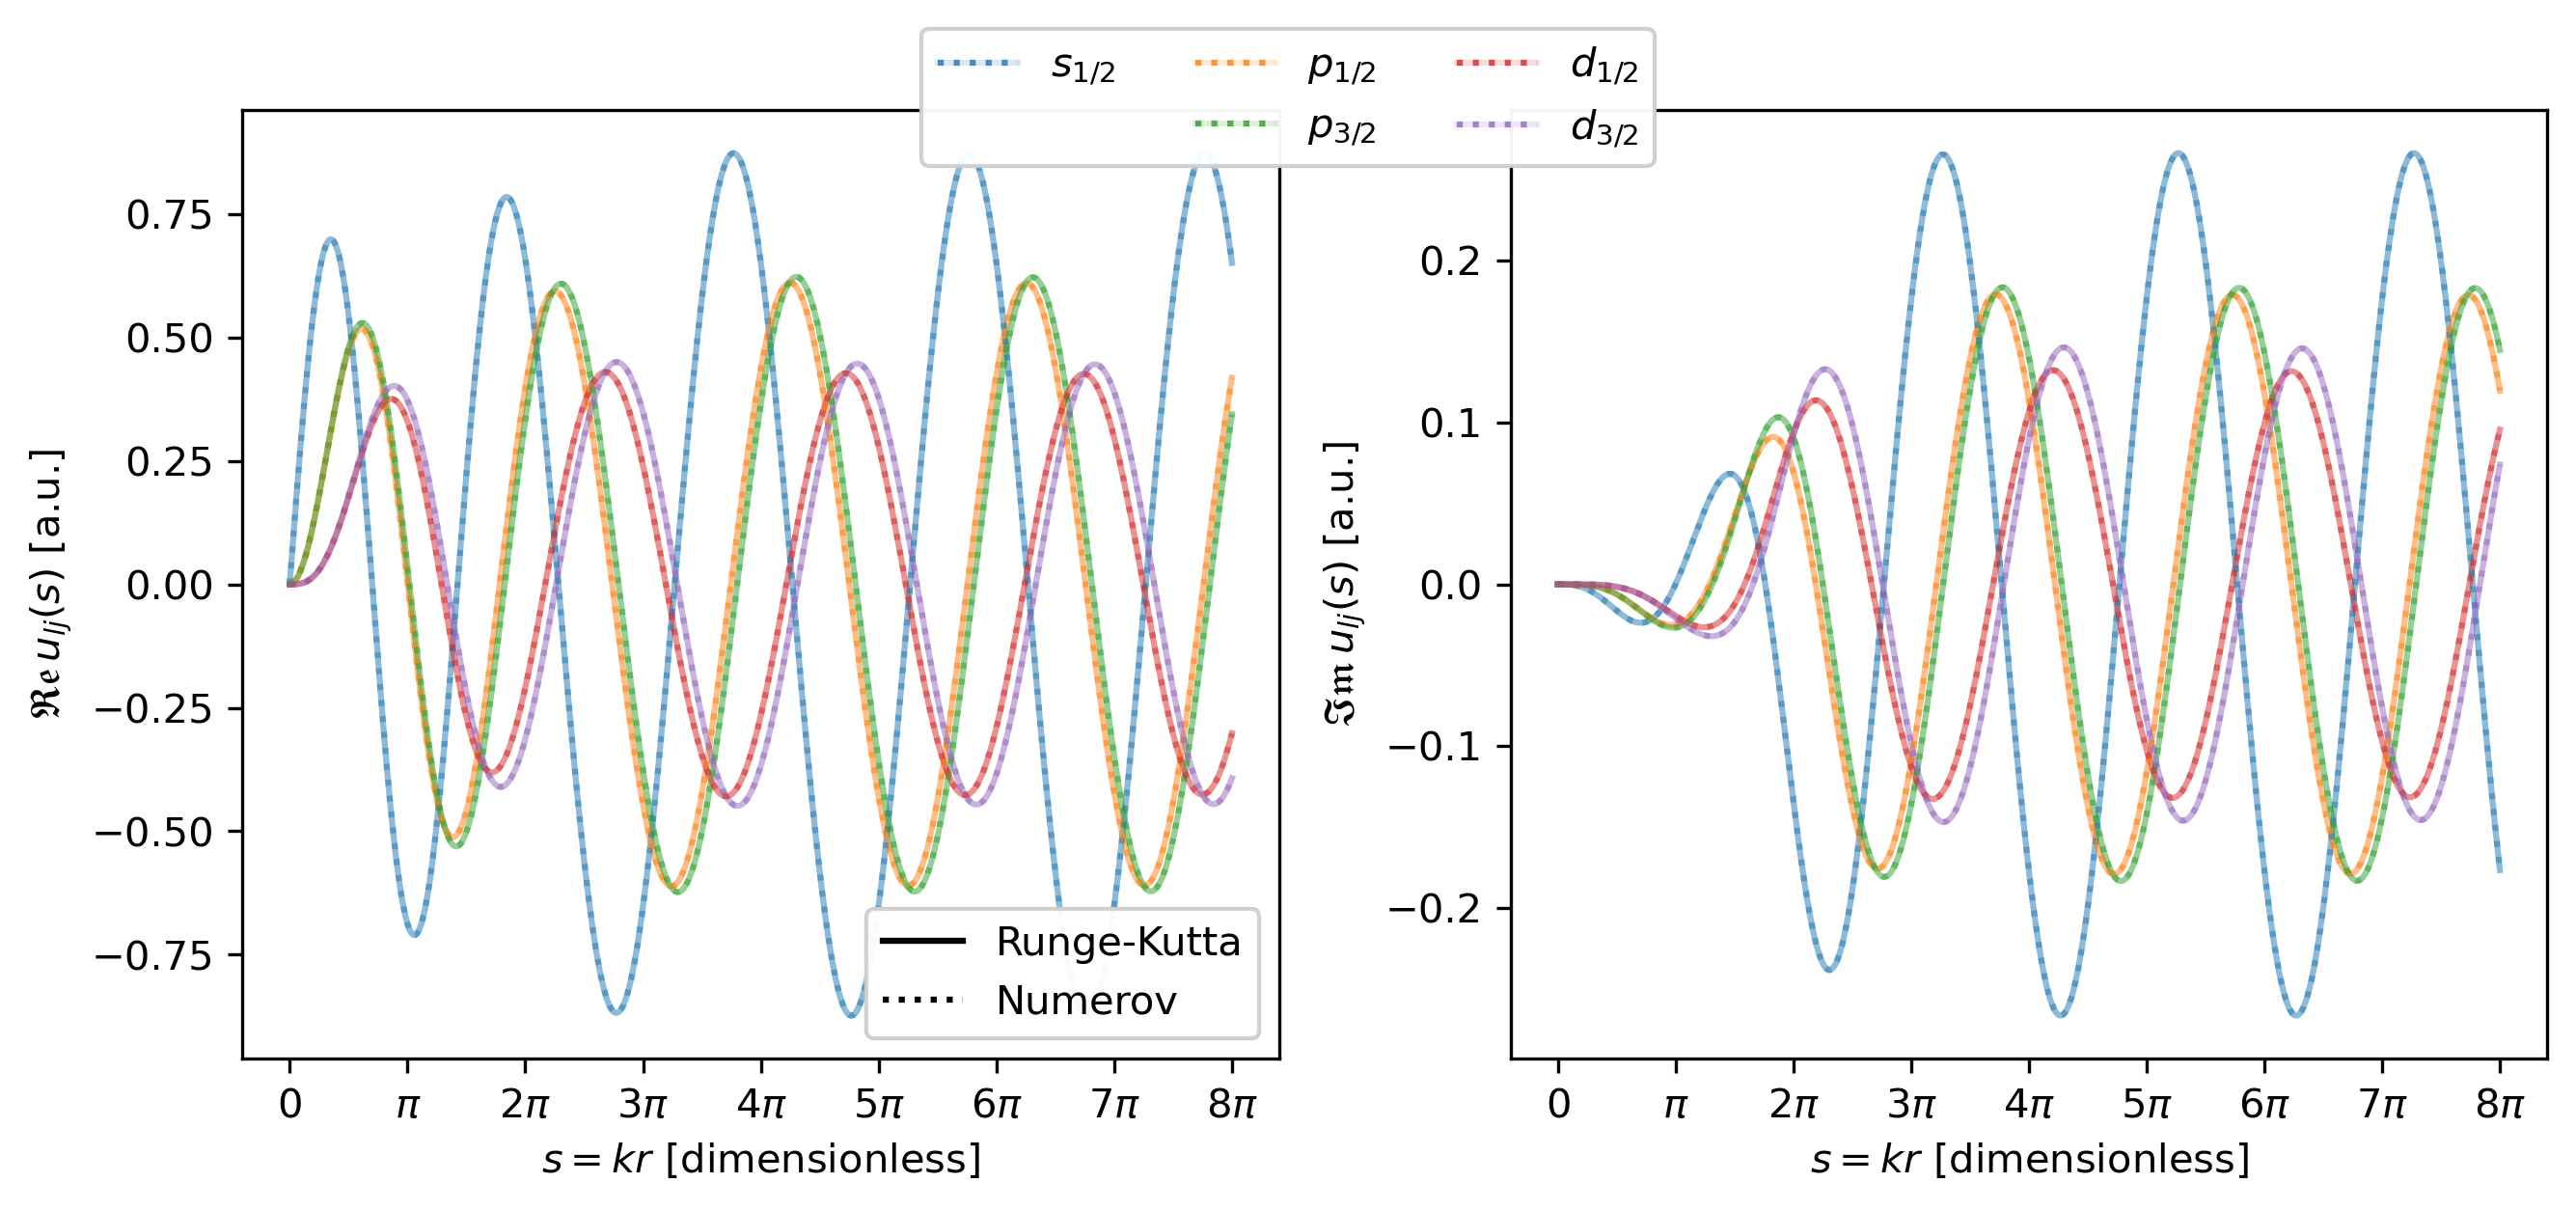

In [6]:
from rose.training import compare_partial_waves
#TODO wavefunction normalization convention
for l in range(len(solutions_rk)):
    for j in range(len(solutions_rk[l])):
        solutions_num[l][j] *= (
            np.max(solutions_rk[l][j].real) / np.max(solutions_num[l][j].real))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
fig.patch.set_facecolor("white")

compare_partial_waves(
    s_mesh,
    [solutions_rk[0:3], solutions_num[0:3]],
    ["Runge-Kutta", "Numerov"],
    fig,
    ax1,
    ax2,
)

Let's take a look at the phase shifts as well:

In [7]:
deltas_rk = ground_truth.exact_phase_shifts(parameters)
deltas_numerov = numerov_solvers[0].exact_phase_shifts(parameters)

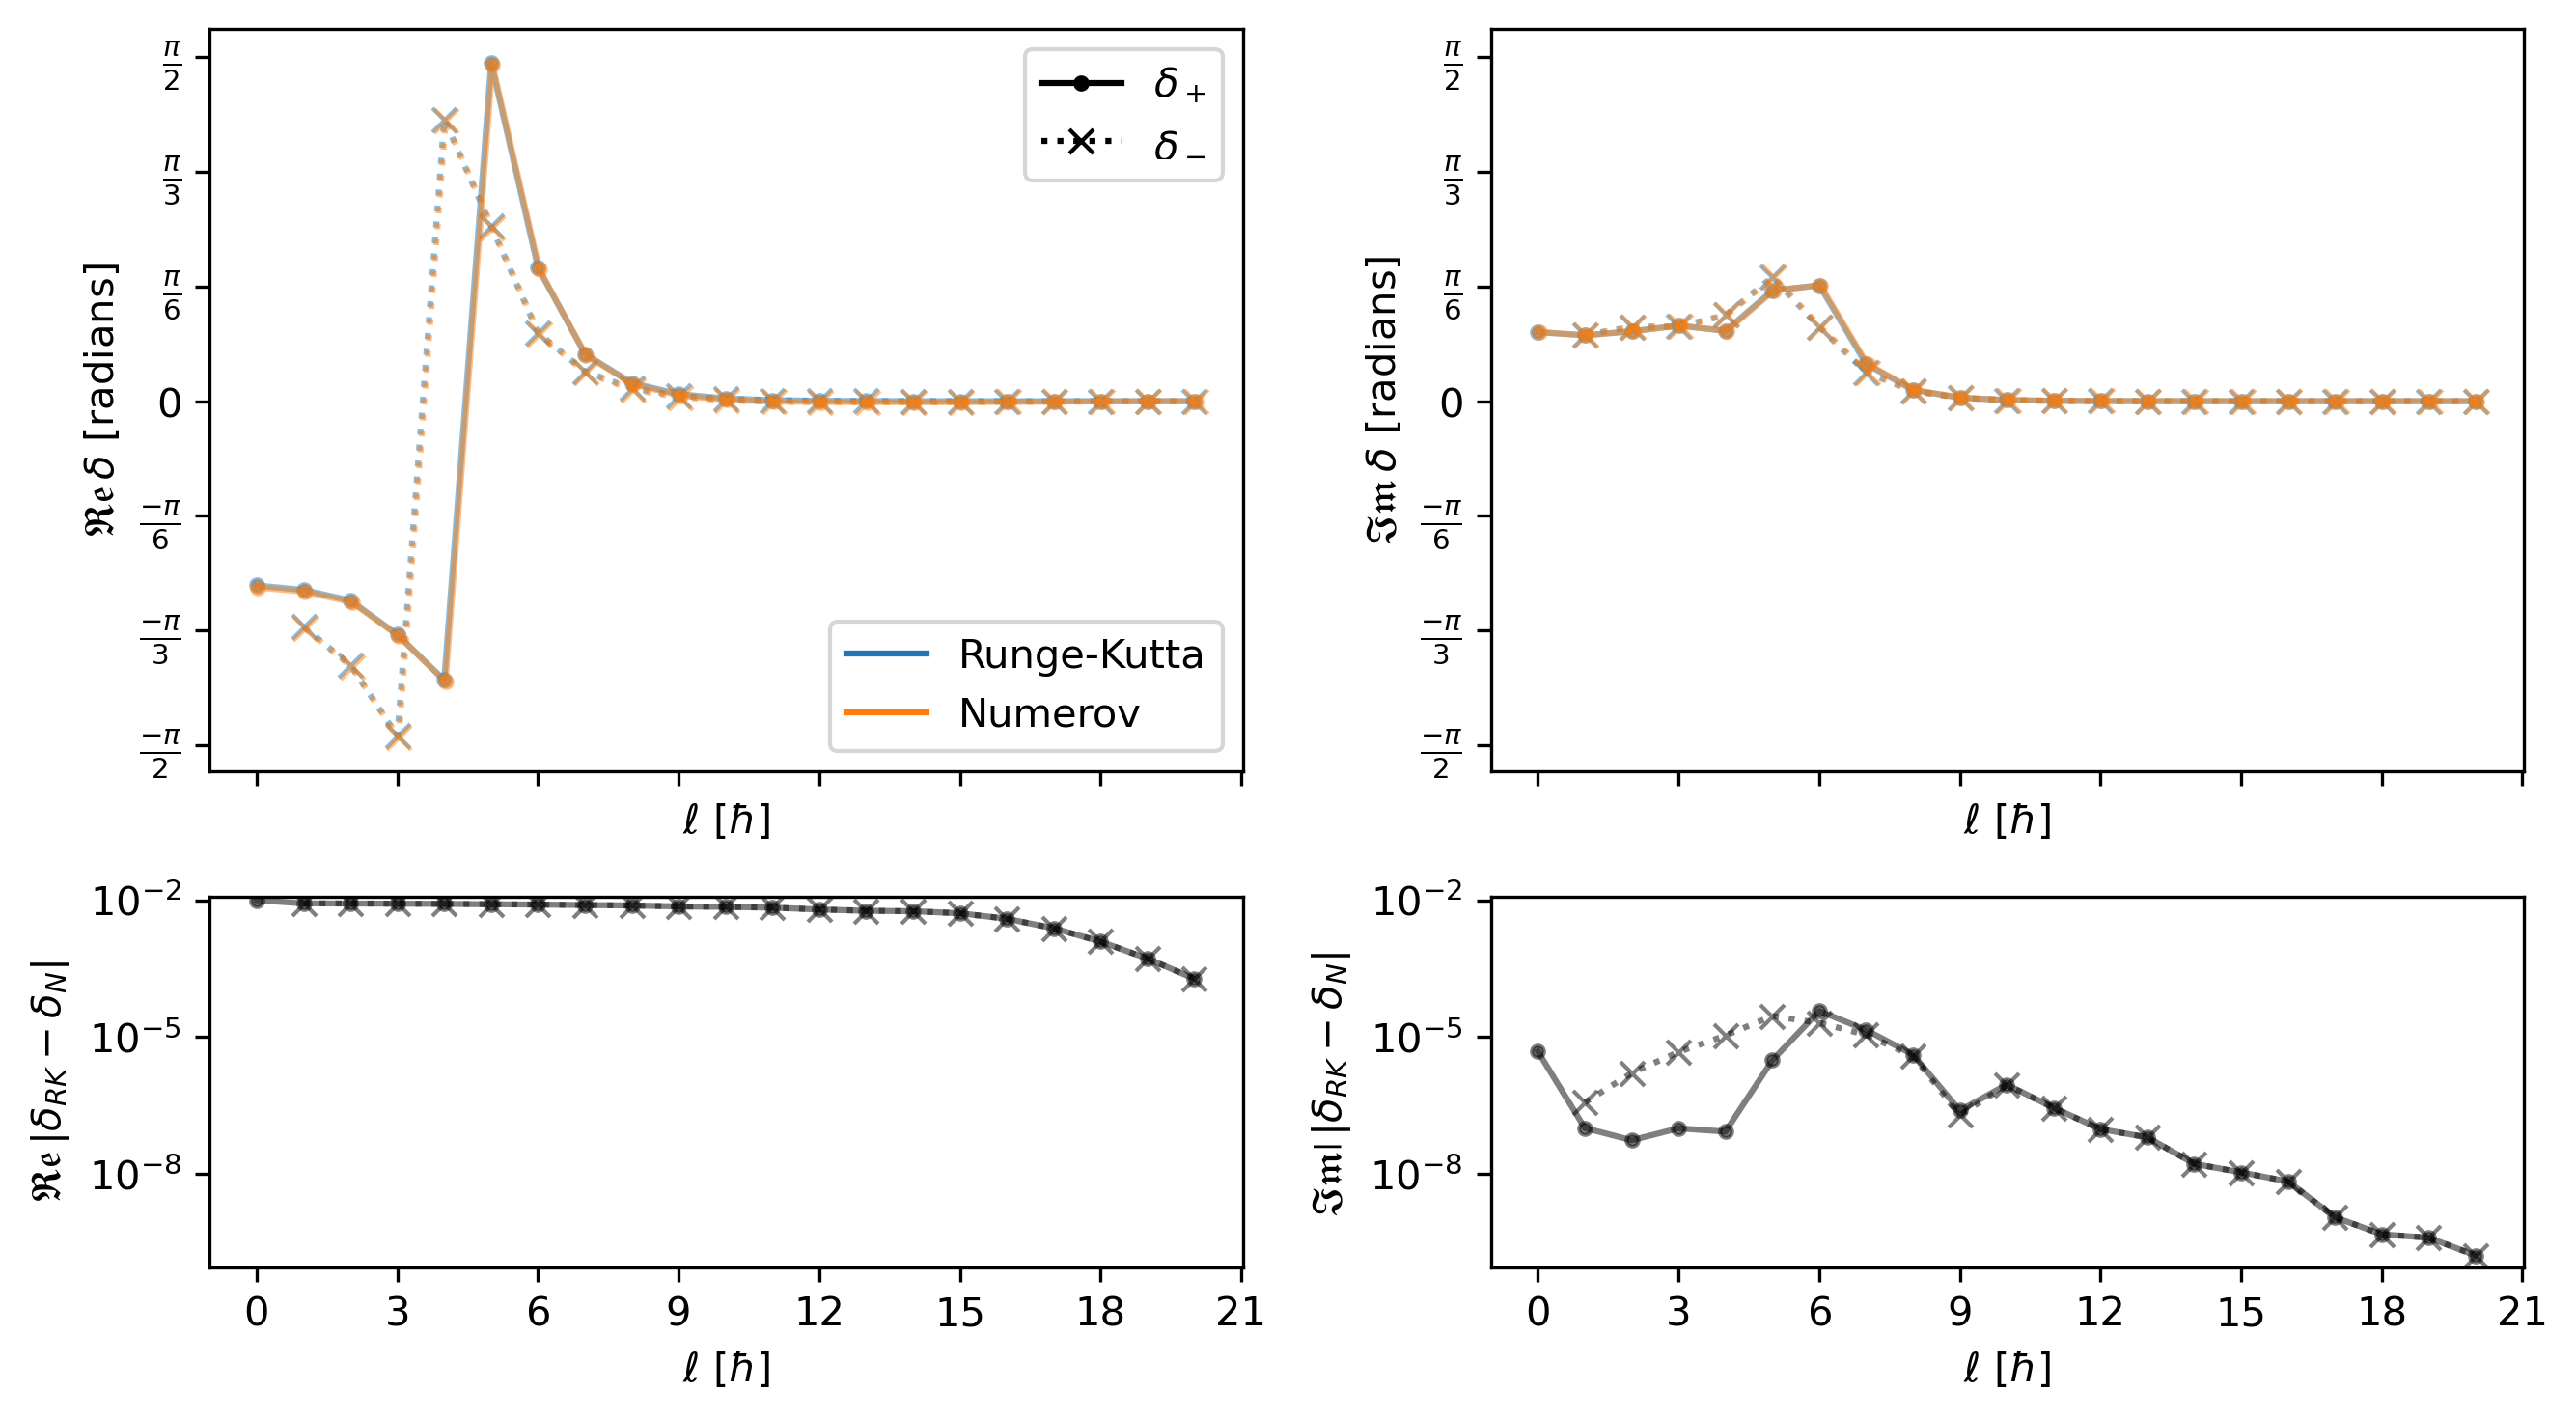

In [8]:
from rose.training import plot_phase_shifts, compare_phase_shifts_err
from matplotlib import ticker

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, sharex=True, figsize=(9, 5), height_ratios=[1, 0.5], dpi=300
)
fig.patch.set_facecolor("white")

compare_phase_shifts_err(
    deltas_rk,
    deltas_numerov,
    "Runge-Kutta",
    "Numerov",
    fig,
    ax1,
    ax2,
    ax3,
    ax4,
    small_label1="RK",
    small_label2="N",
)

plt.tight_layout()

Great, now that we see our solvers produce the same wavefunctions (up to normalization), and phase shifts, let's do a CAT analysis to compare them more rigorously. We will compare differential cross sections at a given energy.

In [9]:
# grab some sample parameters
test_samples = rose.training.sample_params_LHC(100, parameters, 0.8, seed=13)

Let's compare the highest and lowest fidelity Runge-Kutta differential cross sections:

In [10]:
%%time
# calculate ground truth differential cross sections for each sample
ground_truth_output = []
for sample in test_samples:
    ground_truth_output.append(ground_truth.exact_xs(sample).dsdo)

CPU times: user 17min 34s, sys: 456 ms, total: 17min 34s
Wall time: 17min 34s


In [17]:
%%time
# calculate lowfi differential cross sections for each sample to compare
lowfi_solver = numerov_solvers[1]
lowfi_method = "Numerov dx={:1.0e}".format(numerov_dx[1])
lowfi_output = []

for sample in test_samples:
    lowfi_output.append(lowfi_solver.exact_xs(sample).dsdo)

CPU times: user 2min 30s, sys: 3.99 ms, total: 2min 30s
Wall time: 2min 30s


Before we go any further, let's just take a look at a few of  the cross sections from our hifi and lowfi solvers:

Text(0.5, 0, '$\\theta$ [radians]')

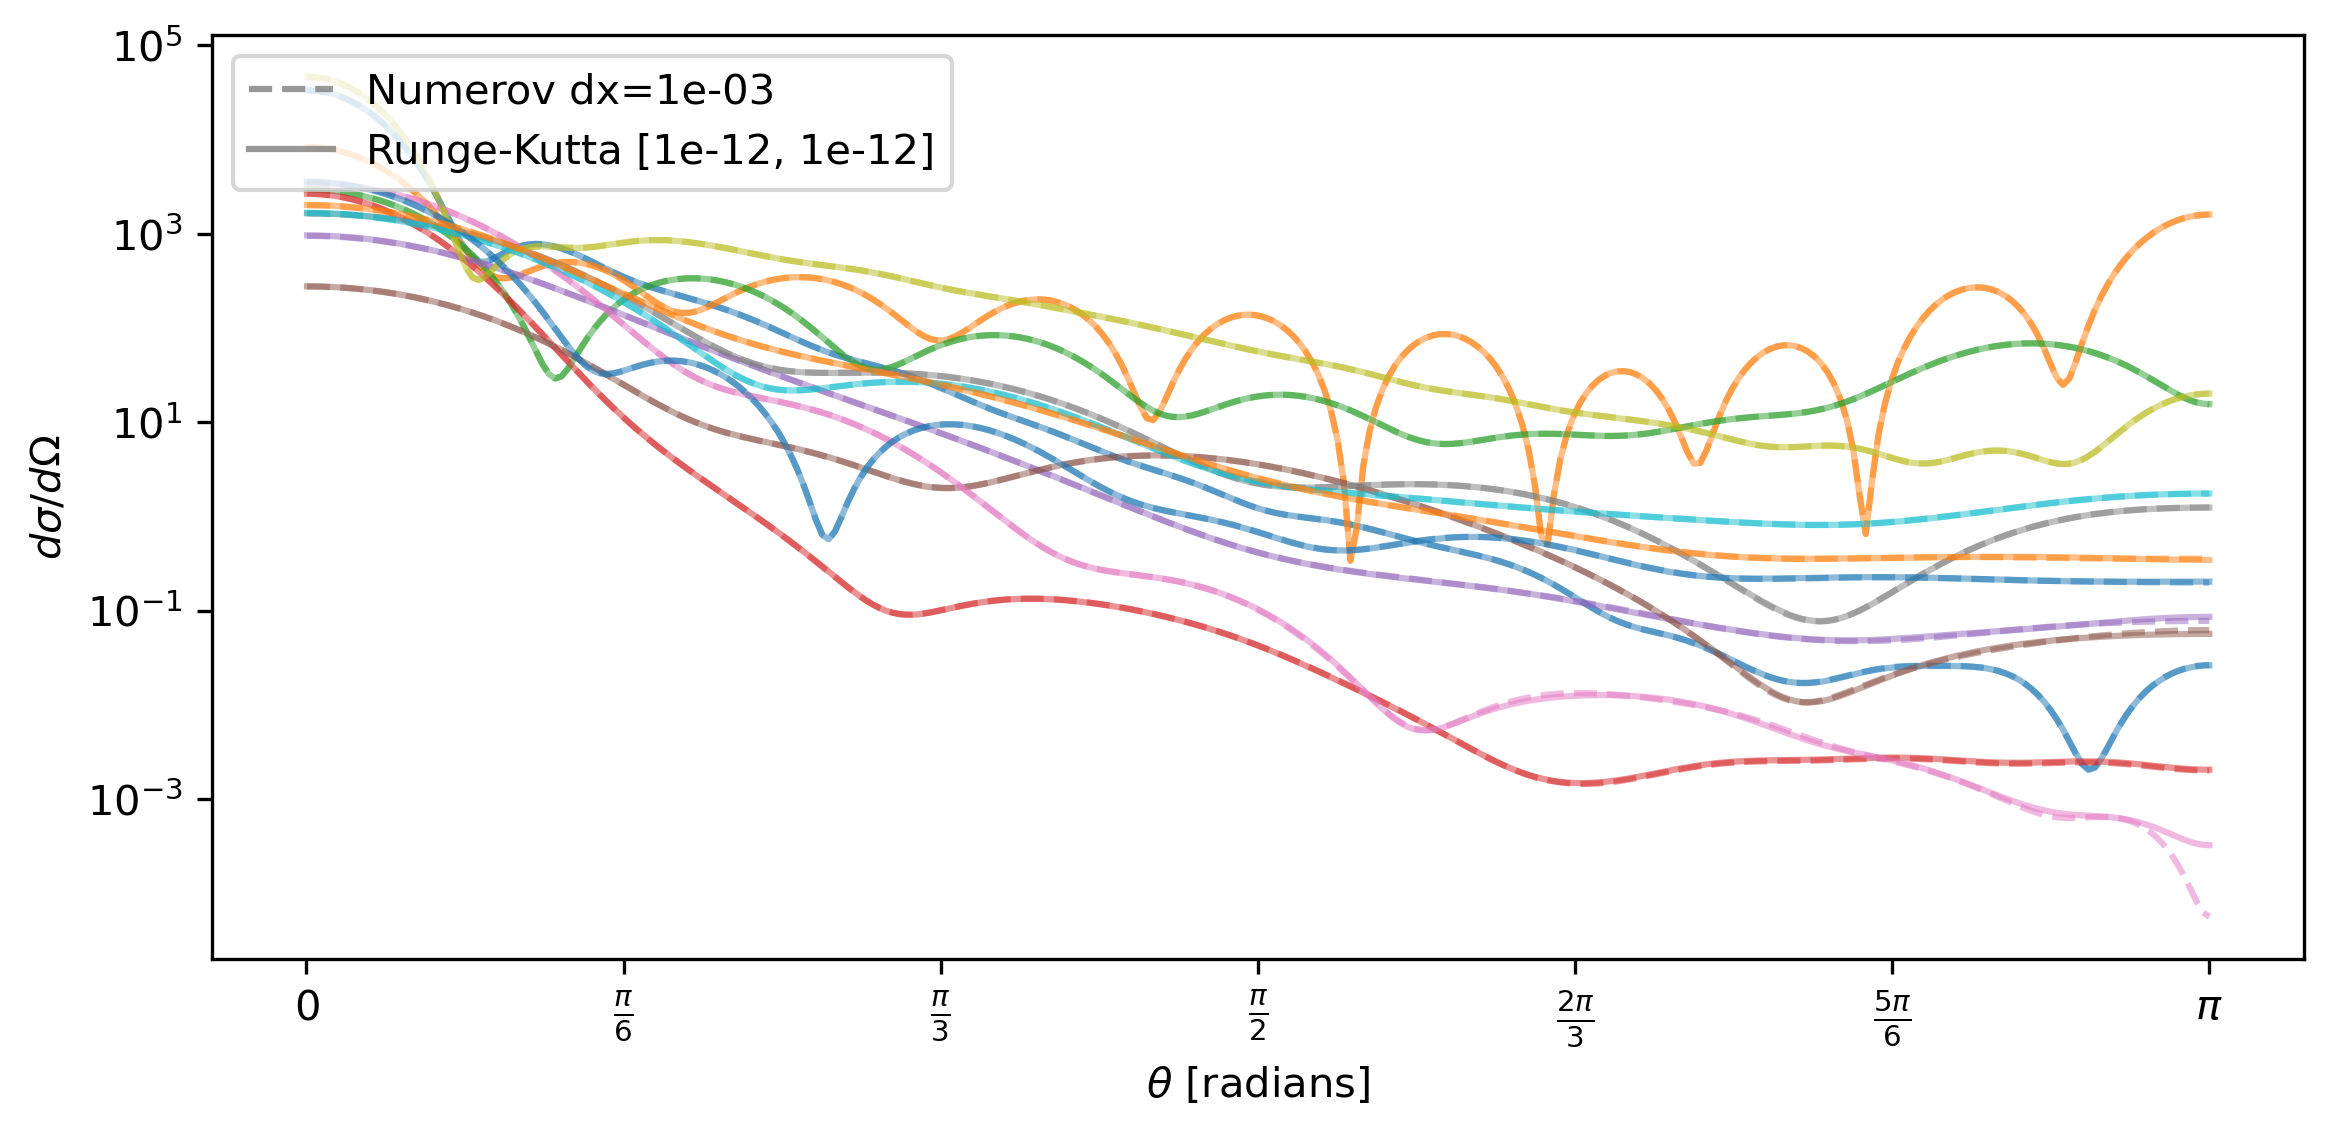

In [18]:
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
fig.patch.set_facecolor("white")

from matplotlib.lines import Line2D
from rose.training import multiple_formatter
# only plot a few
n = 12
for xs_hifi, xs_lowfi in zip(ground_truth_output[n:2*n], lowfi_output[ n:2*n]):
    p = ax.plot(angles, xs_hifi, alpha=0.5)[0]
    ax.plot(angles, xs_lowfi, "--", color=p.get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="tab:gray", linestyle="--", alpha=0.8),
    Line2D([0], [0], color="tab:gray", alpha=0.8),
]
leg = plt.legend(
    legend_styles,
    [lowfi_method, "Runge-Kutta [1e-12, 1e-12]",],
    loc="upper left",
)

ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi/6))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=6)))
ax.set_yscale("log")
ax.set_ylabel(r"$ d \sigma / d\Omega $")
ax.set_xlabel(r"$\theta$ [radians]")

Now let's do a full computational accuracy vs. time (CAT) analysis for all of our interaction parameter samples, to see how the solvers compare.

In [13]:
%%time
# make CAT peformance data sets for each solver
from rose.training import CATPerformance

rk_solver_performances = []
for solver, tols in zip(rk_solvers, rk_tolerances):
    label = r"$\left[{:1.0e} , {:1.0e}\right]$".format(*tols)
    rk_solver_performances.append(
        CATPerformance(
            benchmark_runner=lambda sample: solver.exact_xs(sample).dsdo,
            benchmark_inputs=test_samples,
            benchmark_ground_truth=ground_truth_output,
            label=label,
        )
    )

CPU times: user 13min 28s, sys: 144 ms, total: 13min 28s
Wall time: 13min 28s


In [14]:
%%time
numerov_solver_performances = []
for solver, dx in zip(numerov_solvers, numerov_dx):
    label = r"$dx  = {:1.0e}$".format(dx)
    numerov_solver_performances.append(
        CATPerformance(
            benchmark_runner=lambda sample: solver.exact_xs(sample).dsdo,
            benchmark_inputs=test_samples,
            benchmark_ground_truth=ground_truth_output,
            label=label,
        )
    )

CPU times: user 15min 21s, sys: 216 ms, total: 15min 21s
Wall time: 15min 21s


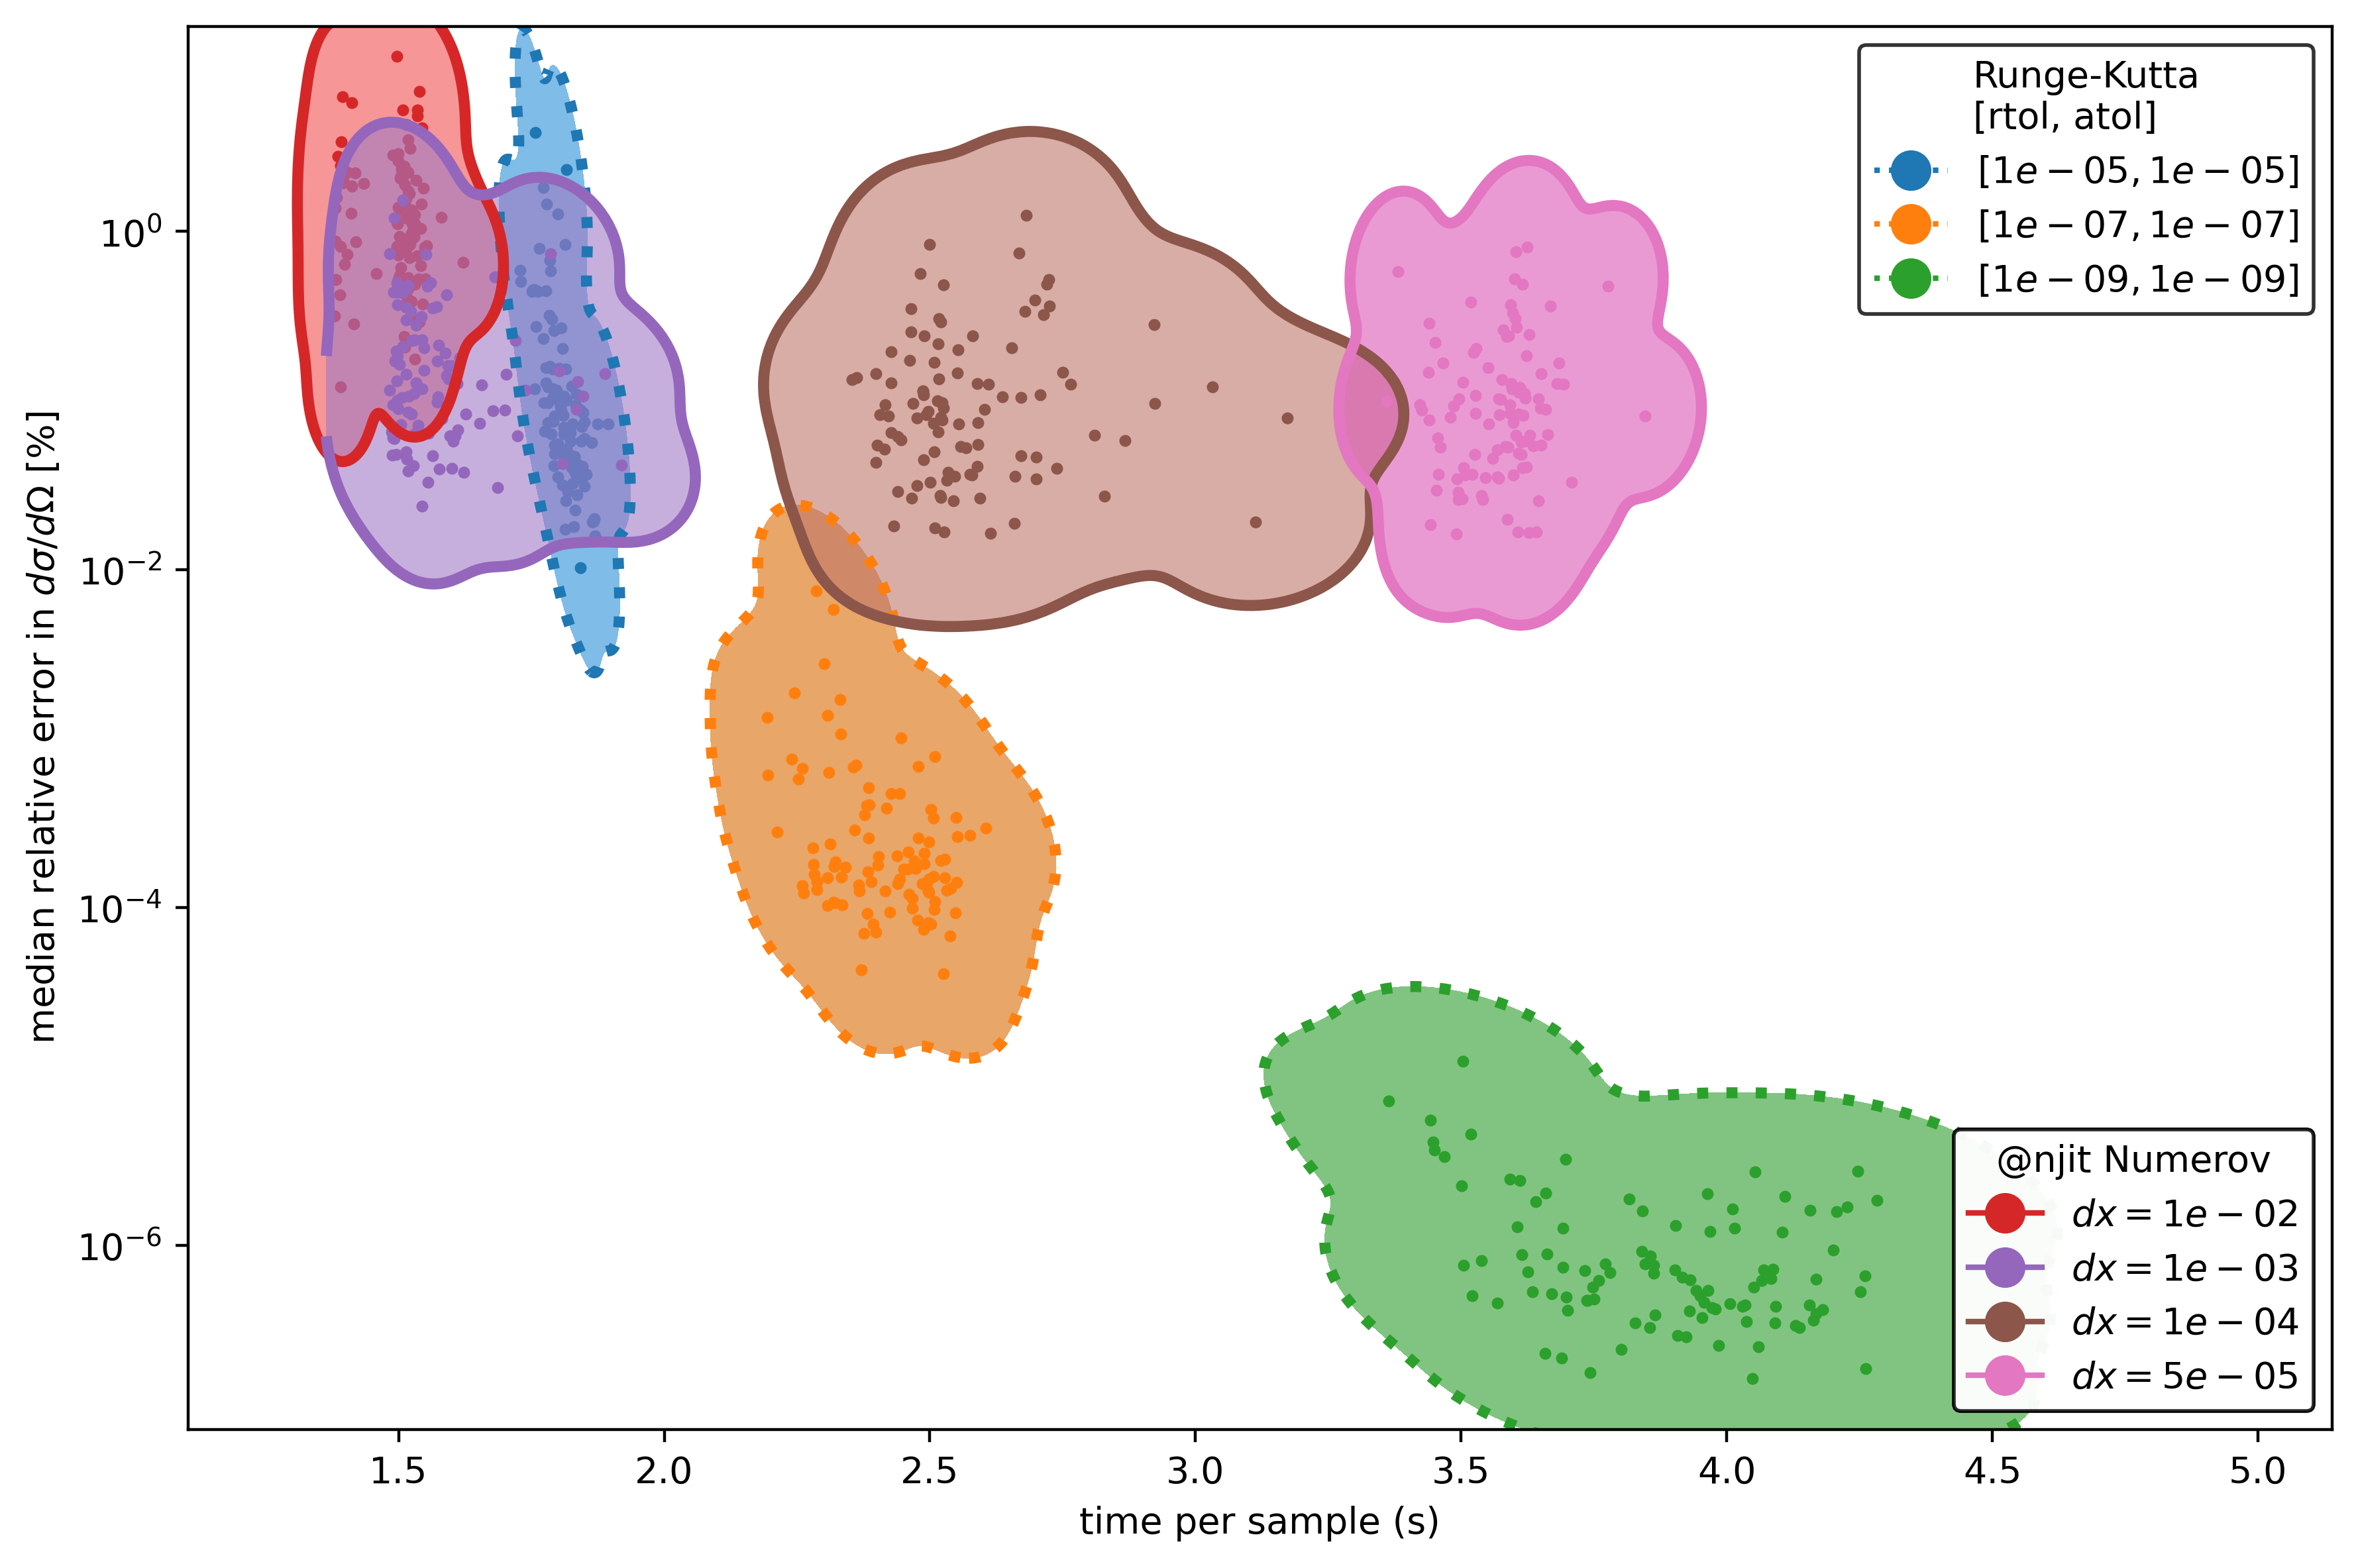

In [15]:
# plot the Computational Accuracy vs. Time (CAT)
from rose.training import CAT_plot
fig, ax = CAT_plot( [rk_solver_performances , numerov_solver_performances], 
                   labels=["Runge-Kutta\n[rtol, atol]", "@njit Numerov"], border_styles=[":", "-"] )
ax.set_ylabel(r"median relative error in $d \sigma / d \Omega$ [%]")
#plt.ylim([10e-8, 100])
plt.xscale("linear")

In [16]:
# write the perf metrics to disk for easy reference later
import pickle
for perf, tols in zip(rk_solver_performances, rk_tolerances):
    label = "RK_{:1.0e}_{:1.0e}".format(*tols)
    with open("perf_{}.pkl".format(label), 'wb') as f:
        pickle.dump(perf, f)
    
for perf, dx in zip(numerov_solver_performances, numerov_dx):
    label = "dx_{:1.0e}".format(dx)
    with open("perf_{}.pkl".format(label), 'wb') as f:
        pickle.dump(perf, f)